In [42]:
%pylab inline
import numpy as np
import pandas as pd
import pylab
import matplotlib.pyplot as plt
import scipy as sp
import glob
from mpl_toolkits.mplot3d import Axes3D

Populating the interactive namespace from numpy and matplotlib


`%matplotlib` prevents importing * from pylab and numpy


In [44]:
prefx = 'cal_1_' # prefix for the gw calibration you want to analyze
path = '/RHESSys/ComoCreek_new/out/cal/'
# load the gw calibration parameters used
gw1 = np.loadtxt(path+prefx+'gw1.txt')
gw2 = np.loadtxt(path+prefx+'gw2.txt')

In [45]:
obs = pd.read_csv('/RHESSys/Comocreek/barnhatb/obs/como_discharge_real_clean.csv', sep=',', header='infer')              

In [46]:
obs.index = pd.date_range(start='2004-01-01',freq='D', periods = len(obs.q_liter_per_day))

In [47]:
obs = obs.drop(['year','doy'], axis = 1)

# Convert Observed Streamflow from L/d to mm/d

In [48]:
area = 5000000 # m^2

In [49]:
streamflow = obs.q_liter_per_day

In [50]:
streamflow = streamflow*0.001 # convert to m3/d

In [51]:
streamflow = streamflow/area # covert to m/d

In [52]:
obs['discharge'] = streamflow*1000 # convert to mm/d

In [53]:
del streamflow

# Aggregate by Water Year

In [54]:
def wateryear(index):
    year = index.year
    strt = pd.datetime(year,10,1) # start of the next water year+1
    
    if index<strt:
        wyear = year
    elif index>=strt: 
        wyear = year+1

    return wyear

In [55]:
obs['wateryear'] = obs.index.map(wateryear)

In [57]:
obs2 = obs.groupby(by='wateryear').sum() # generate yearly sums

In [87]:
obstrain = obs2.loc[(obs2.index>=2005) & (obs2.index<=2010),'discharge'] # pull out the training years of observations

## Loop through each model run and calculate an objective function

In [88]:
from hydro import objective_fxns as ofx
pylab.rcParams['figure.figsize'] = (22.0, 11.0)

In [89]:
files = glob.glob('/RHESSys/ComoCreek_new/out/cal/cal_1_*'+'_basin.daily')

#area = 45069.*(10.*10.) #m^2 area of the RHESSys simulation domain

In [90]:
len(files)

500

In [91]:
from matplotlib.backends.backend_pdf import PdfPages
import datetime

In [109]:
n = len(files)

objectivefxn = np.zeros([n,1]) # preallocate
dischargeyrs = np.zeros([n,4]) # preallocate
strt = 2005
nd = 2010


with PdfPages('/RHESSys/ComoCreek_new/figures/'+prefx+'daily_strmflow_plots.pdf') as pdf:
    for fl in files:
    
        data = pd.read_table(fl,delim_whitespace=True,
                       header='infer', parse_dates={'foo':[2,1,0]}, index_col='foo') # bring in the data
        num = int(fl.split('/')[-1].split('.')[0].split('_')[2]) # pull out the run number, this will be used to index the objective function result into the objectivefxn matix

        data['wateryear'] = data.index.map(wateryear)
        
        data2 = data.groupby(by='wateryear').sum() # compute yearly sums by water year

        simtrain = data2.loc[(data2.index>=strt) & (data2.index<=nd),'streamflow']

        objectivefxn[num] = ofx.nashsut(obstrain,simtrain)

        ## plot each time series as a multi page PDF
    
    
        plt.figure(figsize = (8,5))
        plt.plot(simtrain.index, simtrain, 'b-',
                 obstrain.index, obstrain, 'k-')
        
        plt.title('Simulation '+str(num)+' Streamflow Time Series', fontsize = 20)
        plt.xlabel('Date', fontsize = 16)
        plt.ylabel('Discharge [mm]', fontsize = 16)
        
        #plt.axis([strt,nd,0,60])
        plt.legend(['Simulated','Observed'])
        
        pdf.savefig()
        plt.close()
        
    d = pdf.infodict()
    d['Title'] = prefx+' RHESSys Model Run Discharge Results'
    d['Author'] = 'Theodore Barnhart'
    d['CreationDate'] = datetime.datetime(2014, 7, 24)
    d['ModDate'] = datetime.datetime.today()

    #print num
    #print objectivefxn[num]
    #print data2.streamflow[2004]
    
    #print fl
    
    #del data2
    #del data


In [110]:
np.max(objectivefxn)

0.52051788846519353

In [111]:
idx = argmax(objectivefxn)
print 'Calibration Results'
print 'SNE:',objectivefxn[idx]
print 'gw1:',gw1[idx]
print 'gw2:',gw2[idx]

Calibration Results
SNE: [ 0.52051789]
gw1: 0.264
gw2: 0.038


In [112]:
idx

197

In [113]:
%matplotlib inline
import pylab
pylab.rcParams['figure.figsize'] = (22.0, 11.0)

In [114]:
len(gw1)

500

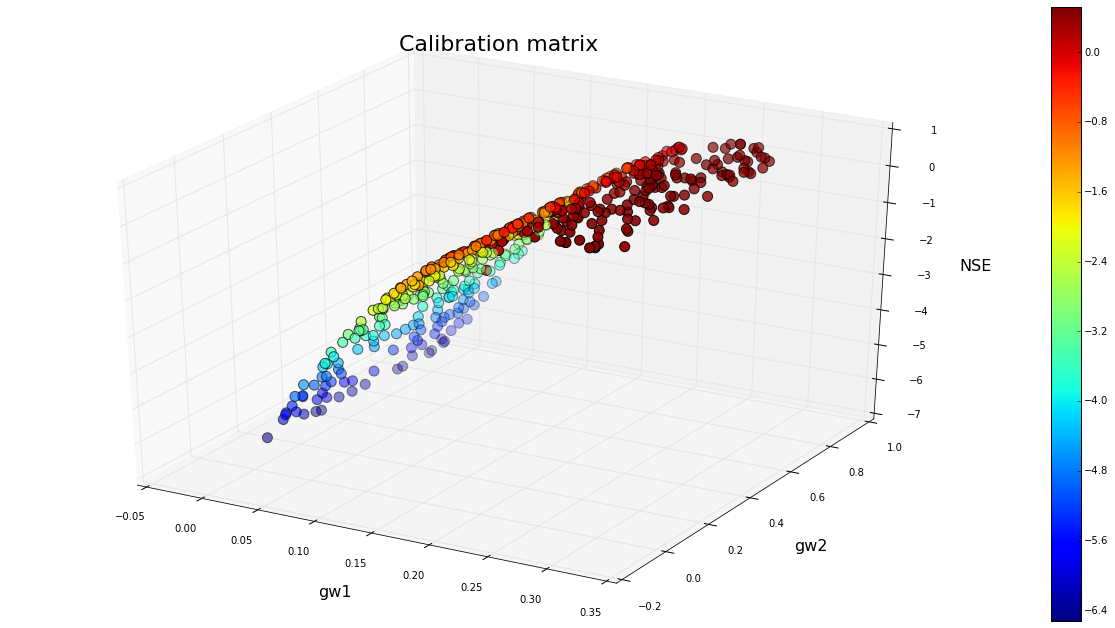

In [115]:
fig = plt.figure()
ax = fig.add_subplot(111,projection = '3d')
#ax = Axes3D(fig)
p = ax.scatter(gw1,gw2,objectivefxn, zdir = 'z', s = 100, c = objectivefxn)

#plt.scatter(gw1,gw2,s = 100, c=objectivefxn)

ax.set_xlabel('gw1', fontsize = 16)
ax.set_ylabel('gw2', fontsize = 16)
ax.set_zlabel('NSE', fontsize = 16)

fig.colorbar(p)
plt.title('Calibration matrix', fontsize = 22)


In [116]:
obstrain

wateryear
2005    209.559407
2006    167.072410
2007    210.560955
2008    148.263297
2009    197.228079
2010    235.453905
Name: discharge, dtype: float64

In [117]:
simtrain

wateryear
2005    160.371738
2006    119.983675
2007    157.277529
2008     95.470084
2009    141.293503
2010    144.868478
Name: streamflow, dtype: float64

In [52]:
ind = np.where(objectivefxn == objectivefxn.max())
ind = ind[0]

In [53]:
objectivefxn[ind]

array([[-0.58274985]])

In [54]:
m[ind]

array([ 0.98])

In [55]:
ksat[ind]

array([ 107.29])

In [56]:
gw2[ind]

array([ 0.28])

In [57]:
gw1

array(0.27)

In [58]:
files[ind]

'/RHESSys/Comocreek/barnhatb/out/cal/cal4_tower_11_basin.daily'

looks like simulation 54 is the best, but lets check this with a log transformed NSE metric.

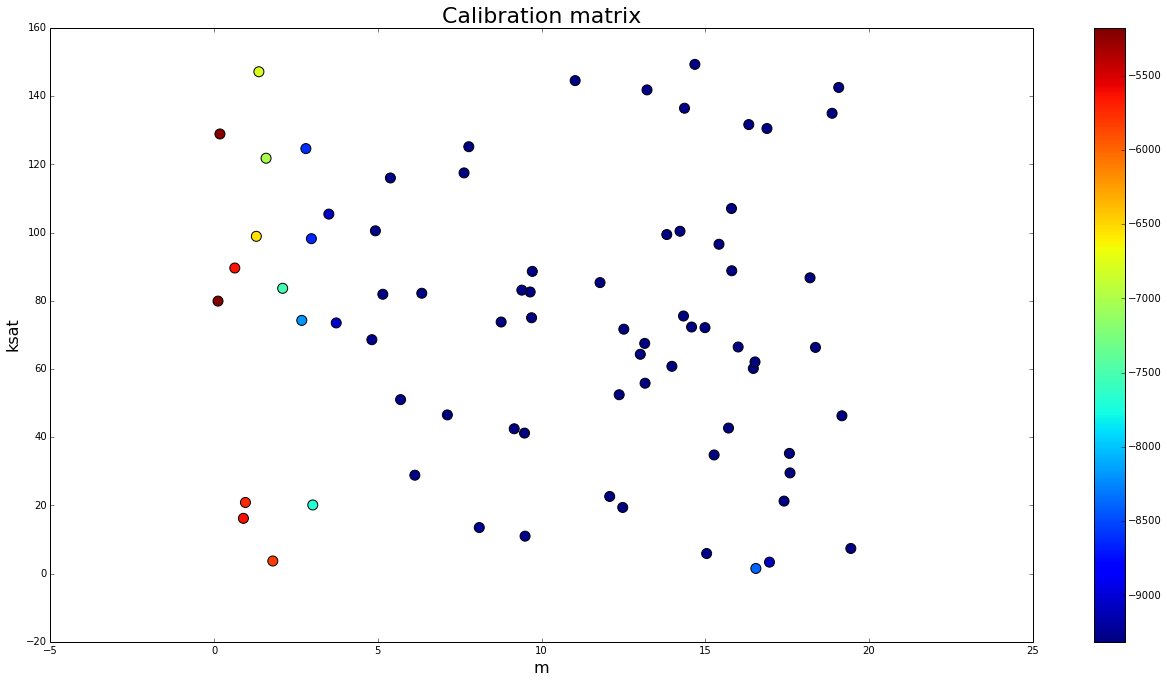

In [60]:
plt.scatter(m,ksat,s = 100, c=objectivefxn)
plt.xlabel('m', fontsize = 16)
plt.ylabel('ksat', fontsize = 16)
plt.colorbar()
plt.title('Calibration matrix', fontsize = 22)

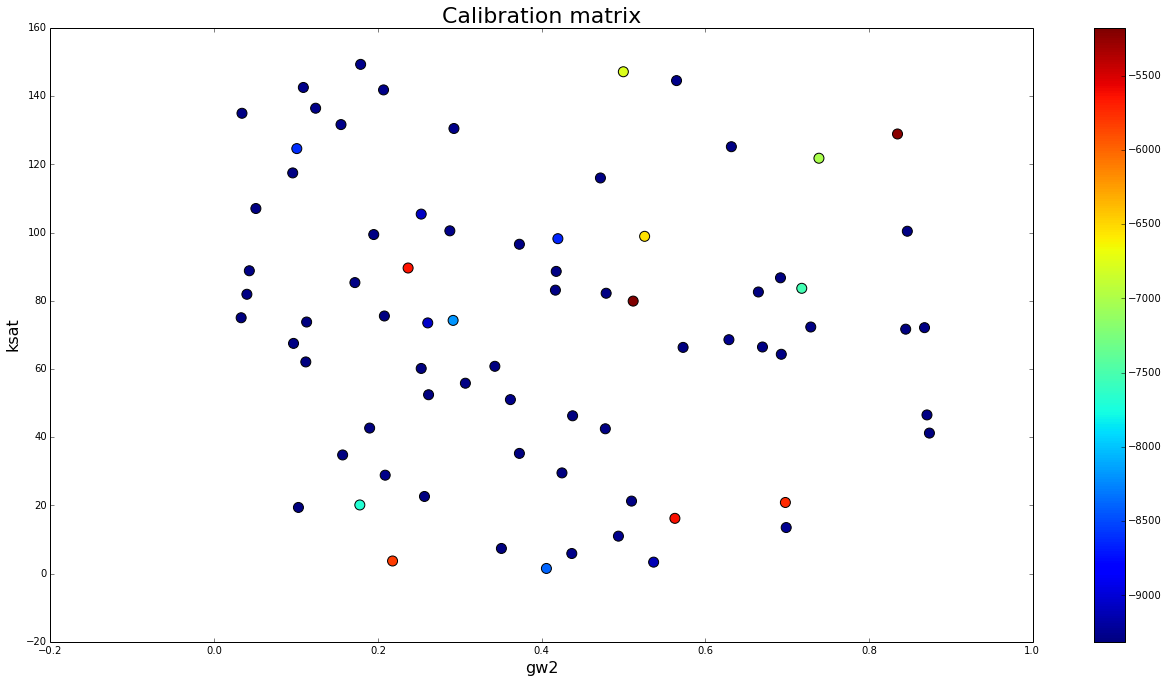

In [61]:
plt.scatter(gw2,ksat,s = 100, c=objectivefxn)
plt.xlabel('gw2', fontsize = 16)
plt.ylabel('ksat', fontsize = 16)
plt.colorbar()
plt.title('Calibration matrix', fontsize = 22)

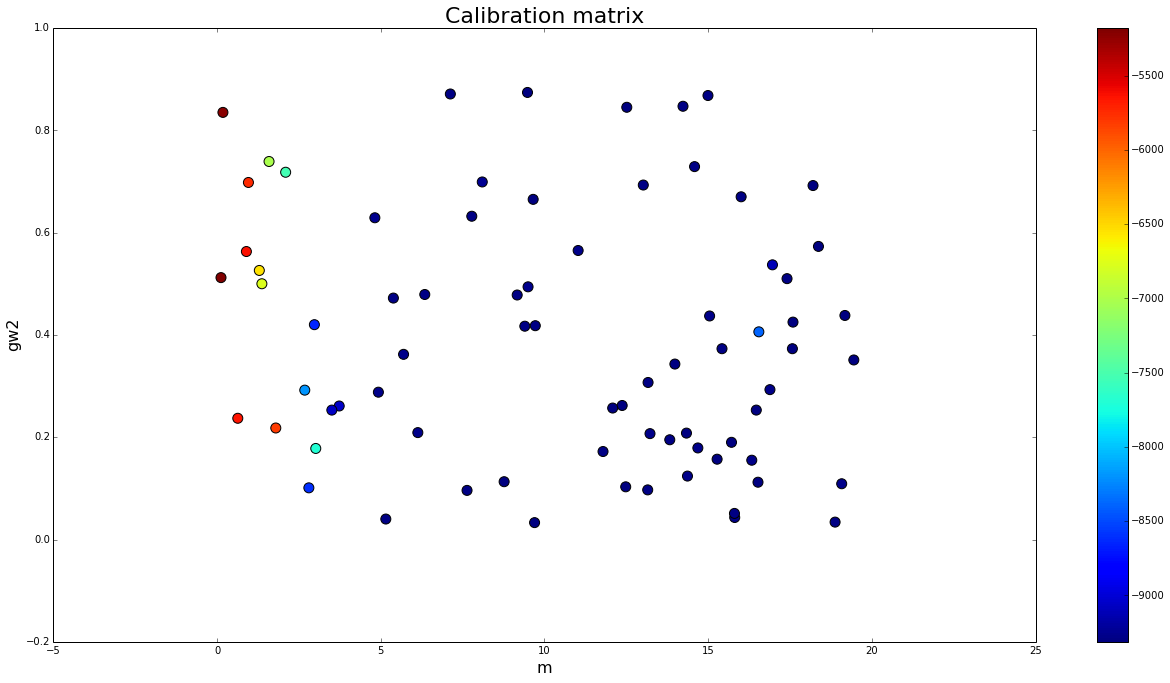

In [62]:
plt.scatter(m,gw2,s = 100, c=objectivefxn)
plt.xlabel('m', fontsize = 16)
plt.ylabel('gw2', fontsize = 16)
plt.colorbar()
plt.title('Calibration matrix', fontsize = 22)

# Compare Hydrographs

In [ ]:
plt.plot()

# Log Transformed NSE

In [25]:
obs3 = np.log(obs)

obs4 = obs3.groupby(lambda x: x.year).sum() # generate yearly sums

obstrain = obs2.discharge[[2004,2005,2007,2009,2011]] # pull out the training years of observations

In [26]:
objectivefxn = np.zeros([len(files),1]) # preallocate
dischargeyrs = np.zeros([len(files),5]) # preallocate

for fl in files:
    data = pd.read_table(fl,delim_whitespace=True,
                   header='infer', parse_dates={'foo':[2,1,0]}, index_col='foo') # bring in the data
    num = int(fl.split('_')[1]) # pull out the run number, this will be used to index the objective function result into the objectivefxn matix
    
    ## convert mm/d to m3/s
    
    #streamflow = data.streamflow/(10*100) # convert to m/d
    #streamflow = streamflow*area # convert to m3/day
    #data['discharge'] = streamflow/(24*60*60) # convert to m3/s
    
    #plt.plot_date(data.index, data.streamflow, 'k-')
    
    #del streamflow
    data = np.log(data) # log transform
    data2 = data.groupby(lambda x: x.year).sum() # compute yearly sums
    
    simtrain = data2.streamflow[[2004,2005,2007,2009,2011]]
    
    dischargeyrs[num,:] = simtrain
    
    objectivefxn[num] = ofx.nashsut(obstrain,simtrain)

#    print num
#    print objectivefxn[num]
#    print data2.streamflow[2004]
    
#    print fl
    
#    del data2
#    del data


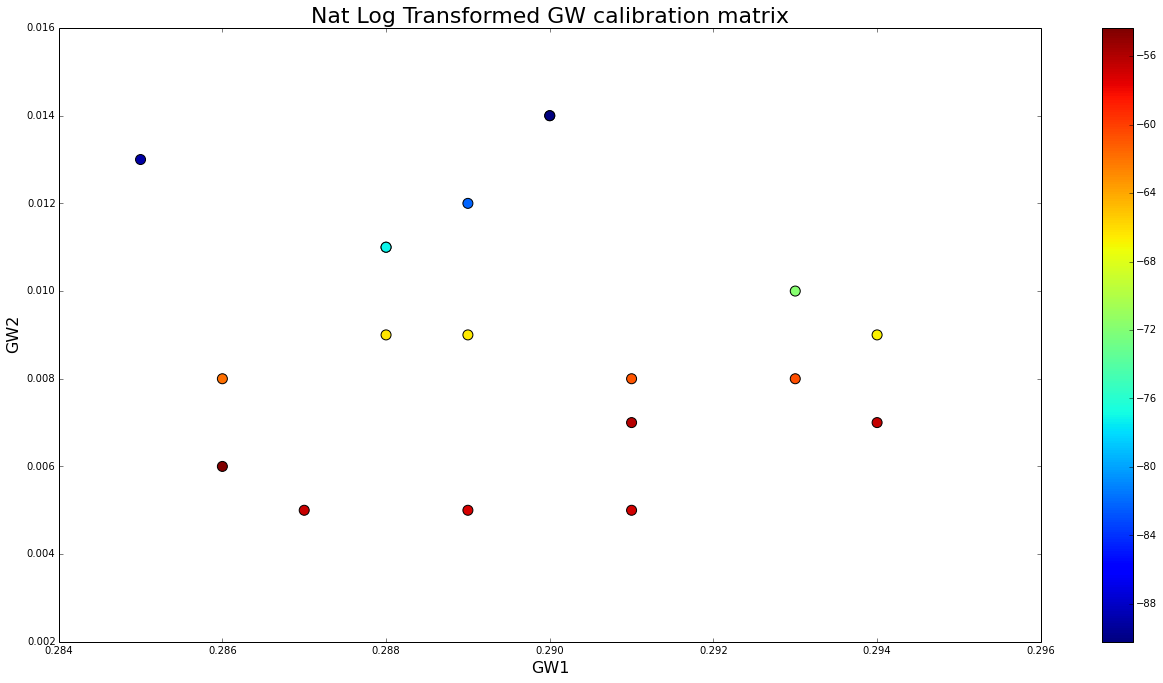

In [27]:
plt.scatter(gw1,gw2,s = 100, c=objectivefxn)
plt.ylabel('GW2', fontsize = 16)
plt.xlabel('GW1', fontsize = 16)
plt.colorbar()
plt.title('Nat Log Transformed GW calibration matrix', fontsize = 22)

In [28]:
ind = np.where(objectivefxn == objectivefxn.max())
ind = ind[0]

In [29]:
objectivefxn[ind]

array([[-54.35395535]])

In [30]:
gw1[ind]

array([ 0.286])

In [31]:
gw2[ind]

array([ 0.006])

In [32]:
files[ind]

'./Comocreek/barnhatb/out/cal/cal6_3_basin.daily'

In [35]:
fl = files[0]

In [36]:
data = pd.read_table(fl,delim_whitespace=True,
                       header='infer', parse_dates={'foo':[2,1,0]}, index_col='foo') # bring in the data

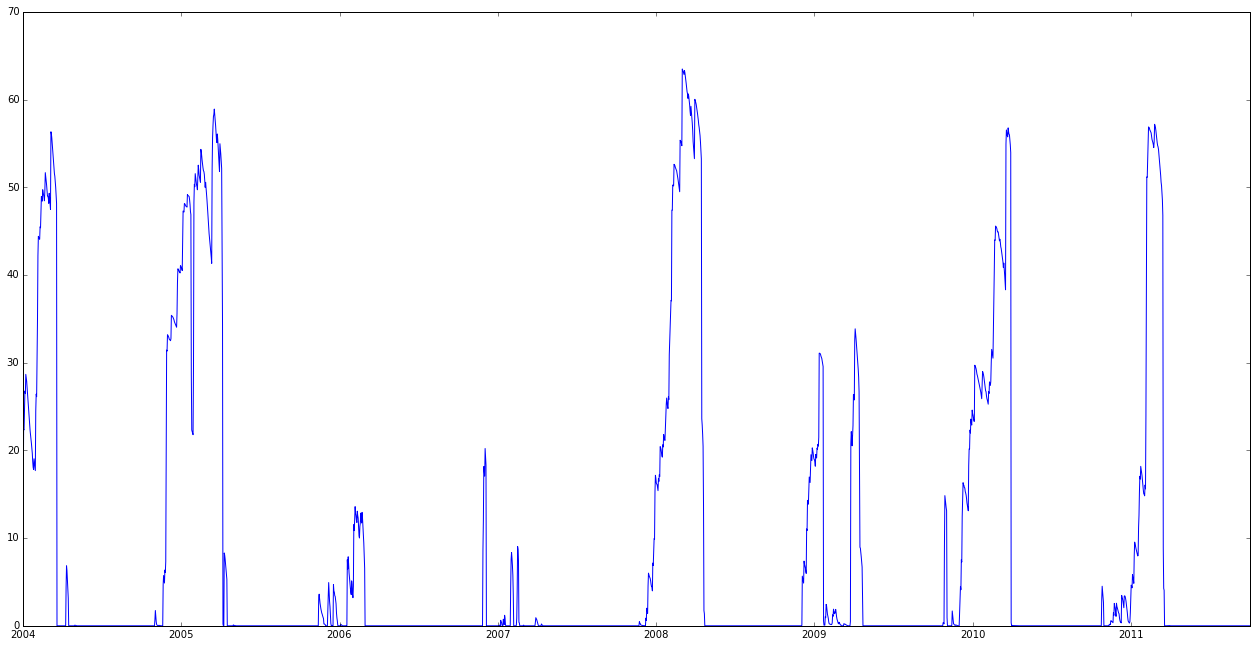

In [39]:
plt.plot(data.index,data.snowpack)

Same result as the non-log transformed data. 

Because the parameter set selected is at the edge of the parameter space simulated over, conduct another set of simulations honing in on the area.